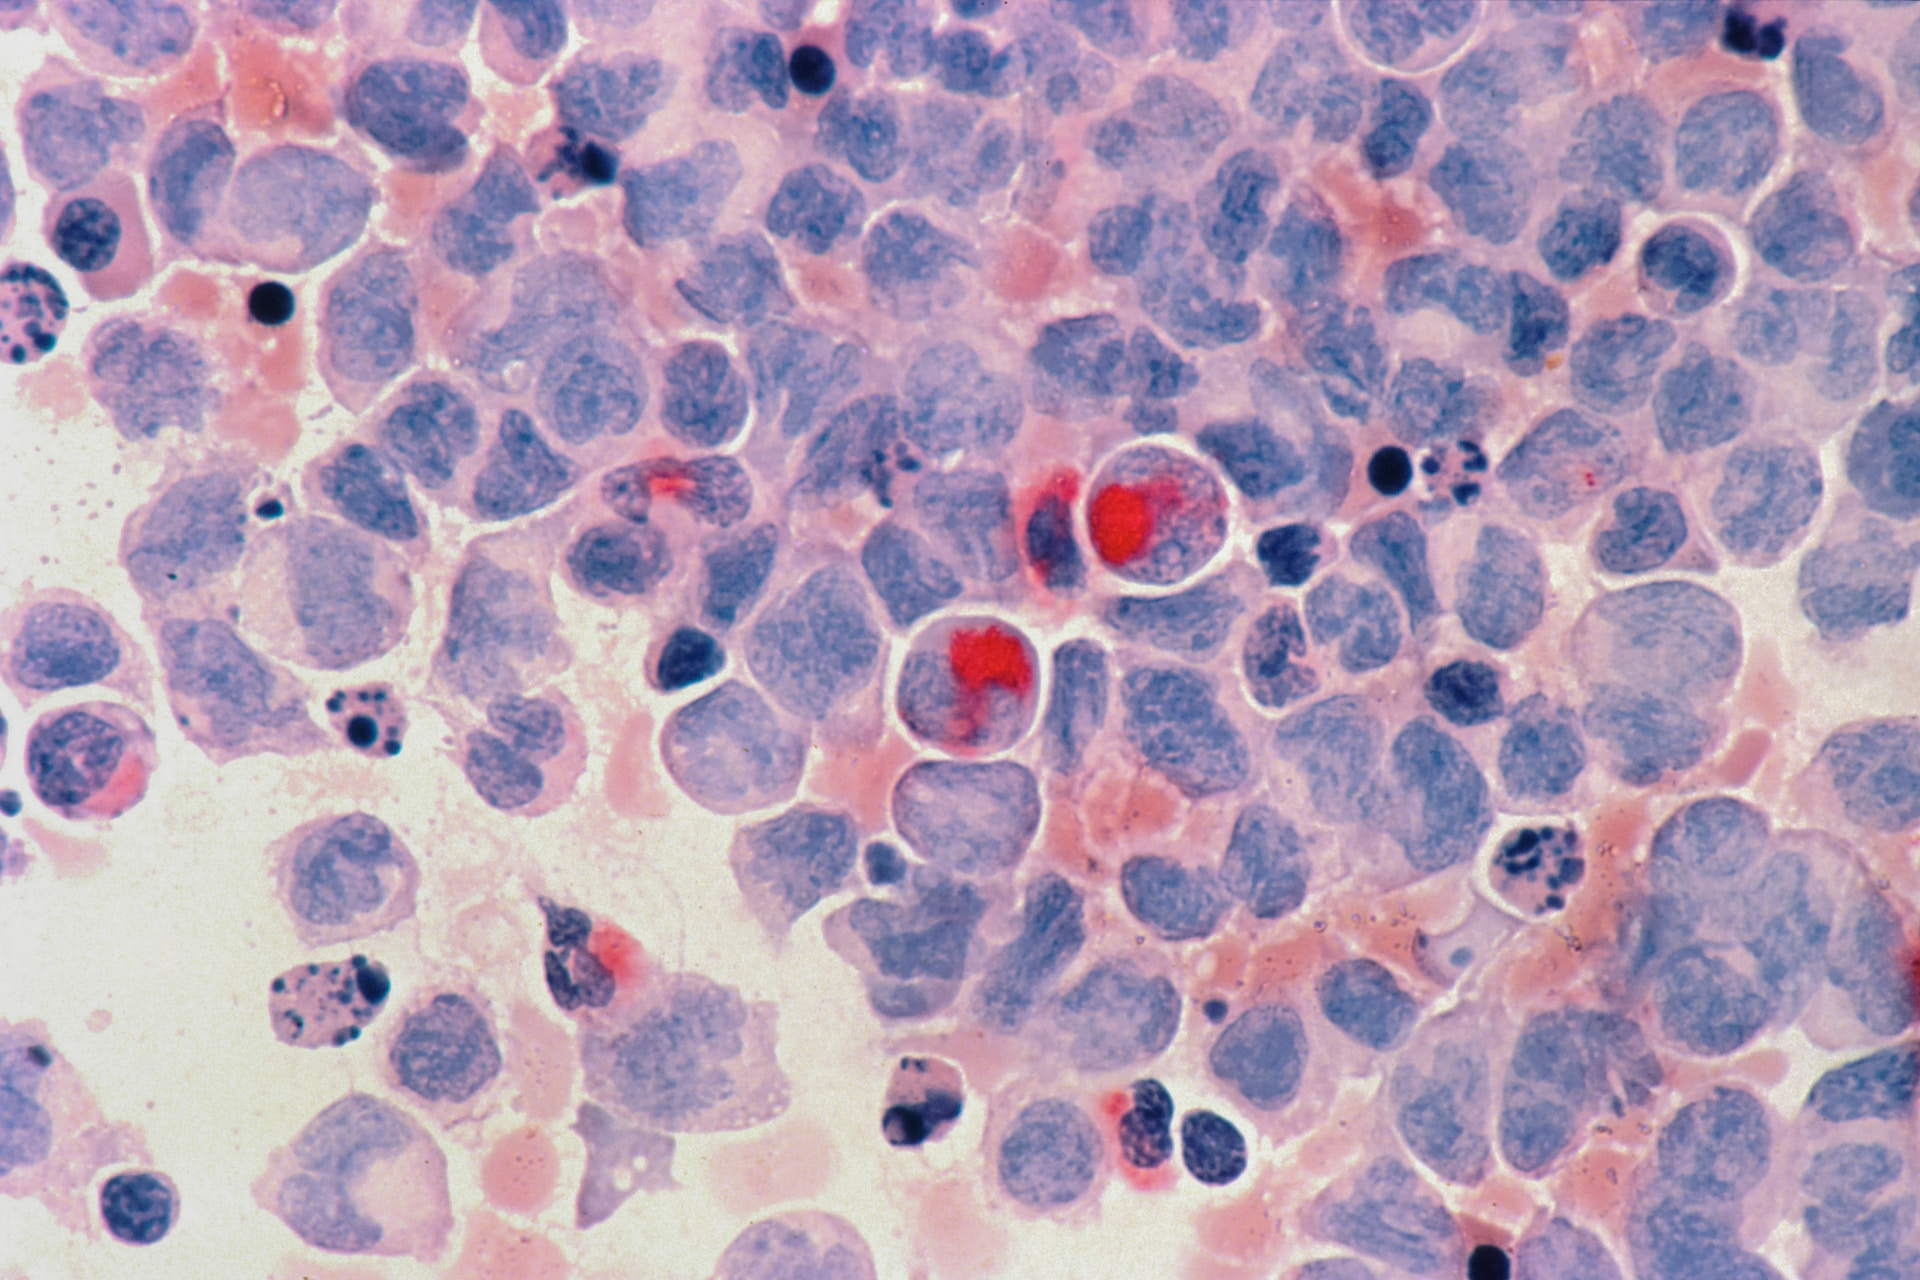

**Data set from open-access paper published December 10, 2020 : https://journals.plos.org/plosmedicine/article?id=10.1371/journal.pmed.1003489**

Dataset used : Debernardi et al 2020 data.csv

This dataset contains information from 590 patients:

Healthy controls (183)
Patients with non-cancerous pancreatic conditions, like chronic pancreatitis (208)
Patients with pancreatic cancer (199)
Our goal is to try to predict which patients have pancreatic cancer based on the features.

In [11]:
#author : Adithya N Raj // 27-02-2024 : 10:15:02
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/My\ Drive/Debernardi-et-al-2020-data.csv /content/
df = pd.read_csv('Debernardi-et-al-2020-data.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.54000,41.088000,NaN


In [4]:
cols = df.columns.to_list()
df.diagnosis = df.diagnosis == 3
df.sex = df.sex.map({'M': 1, 'F': 0})
df = df[['creatinine',
         'plasma_CA19_9',
         'age',
         'sex',
         'LYVE1',
         'REG1B',
         'TFF1',
         'diagnosis']].copy()
df.head(20)

,creatinine,plasma_CA19_9,age,sex,LYVE1,REG1B,TFF1,diagnosis
0,1.83222,11.7,33,0,0.893219,52.94884,654.282174,False
1,0.97266,NaN,81,0,2.037585,94.46703,209.488250,False
2,0.78039,7.0,51,1,0.145589,102.36600,461.141000,False
3,0.70122,8.0,61,1,0.002805,60.57900,142.950000,False
4,0.21489,9.0,62,1,0.000860,65.54000,41.088000,False
5,0.84825,NaN,53,1,0.003393,62.12600,59.793000,False
6,0.62205,NaN,70,1,0.174381,152.27700,117.516000,False
7,0.89349,11.0,58,0,0.003574,3.73000,40.294000,False
8,0.48633,NaN,59,0,0.001945,7.02100,26.782000,False
9,0.61074,24.0,56,0,0.278778,83.92800,19.185000,False


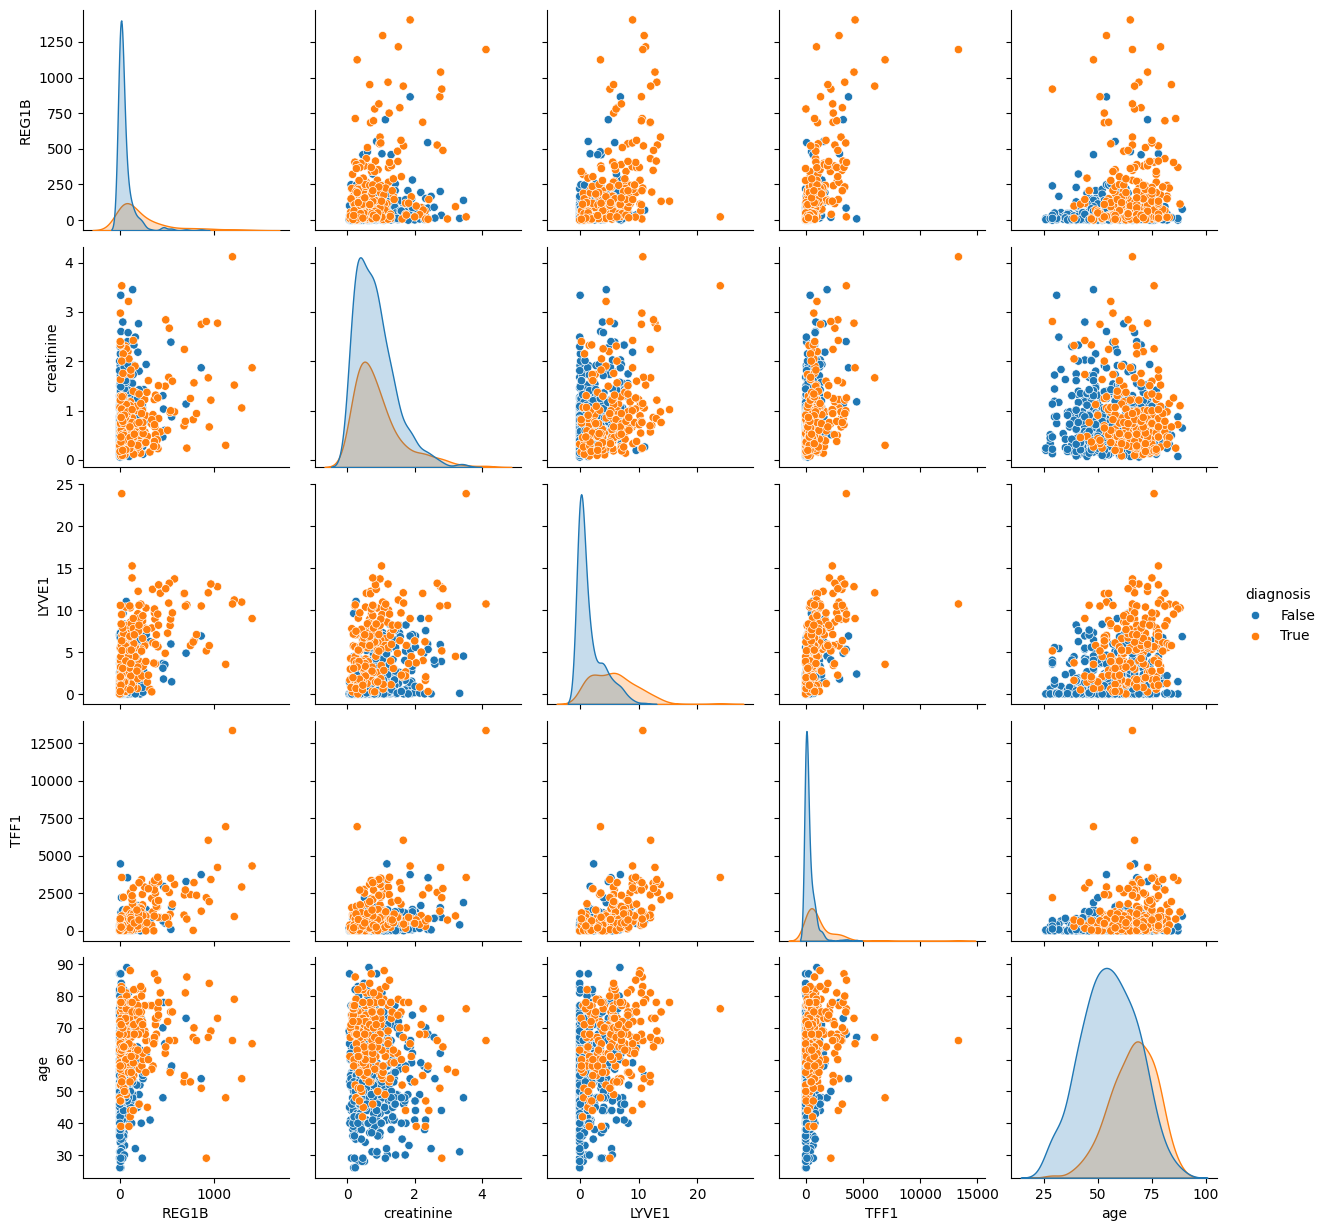

In [5]:
sns.pairplot(data = df, vars=['REG1B', 'creatinine', 'LYVE1', 'TFF1', 'age'], hue='diagnosis', diag_kind='kde')

Observation : It seems that there is a higher frequency of low values for REGB1 in negative diagnoses (FALSE) than in positive diagnoses (TRUE). Similarly, in the case of TFF1, the values appear to be higher in positive diagnoses, and small values seem to be more frequent in negative diagnoses. The distribution of LYVE1 values with respect to the diagnosis looks promising, as there is a higher probability of high values in the case of a positive diagnosis (TRUE), and a higher probability of low values in the case of negative diagnoses (FALSE) and the distributions are more separated.

<Axes: >

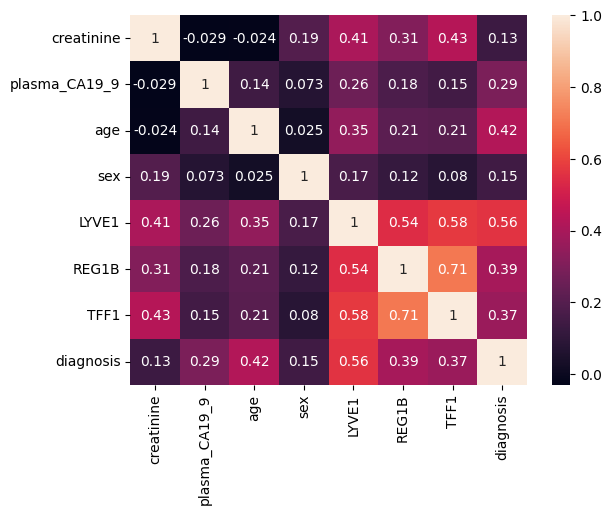

In [6]:
corr = df.dropna().corr()
sns.heatmap(corr, annot=True)

As we can observe, LYVE1 has a higher correlation with the diagnosis, just as we expected based on the visualization of the previous data.

Best parameters:  {'rf__max_depth': 10, 'rf__n_estimators': 100}
Best score:  0.8706117021276597
Test set accuracy:  0.847457627118644


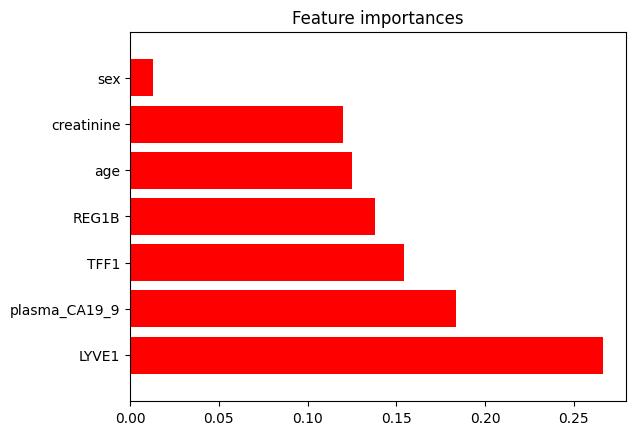

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.impute import SimpleImputer

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for RandomForest, use imputer to change NaN values to mean.
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('rf', RandomForestClassifier())
])

# Define the grid of parameters to search over
param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [None, 5, 10]
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=10)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Select the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Print the accuracy of the best model on the test set
print("Test set accuracy: ", accuracy_score(y_test, y_pred))

# Get feature importances from the best model
importances = best_model.named_steps['rf'].feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()

now XGBoost can operate taking NaNs into account.

Best parameters:  {'xgb__learning_rate': 0.01, 'xgb__n_estimators': 200}
Best score:  0.8855767077267638
Classification report: 
               precision    recall  f1-score   support

       False       0.91      0.94      0.93        80
        True       0.86      0.82      0.84        38

    accuracy                           0.90       118
   macro avg       0.89      0.88      0.88       118
weighted avg       0.90      0.90      0.90       118

Balanced accuracy:  0.8766447368421053


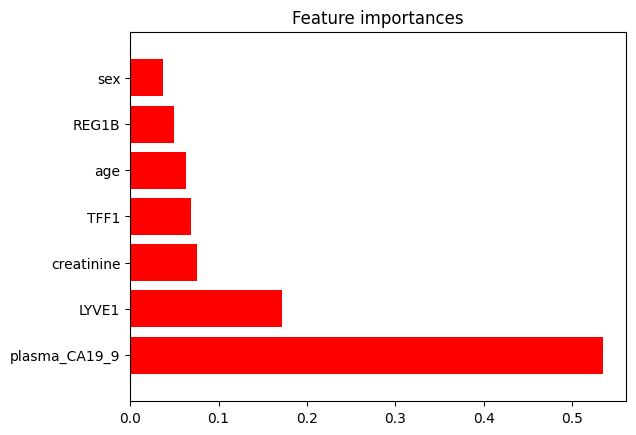

: ) YOU ARE WLCOME DEEPU : )


In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import  classification_report, balanced_accuracy_score

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for scaling and XGBoost
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss'))
])

# Define the grid of parameters to search over
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Create the grid search object
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

# Select the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Print the classification report
print("Classification report: \n", classification_report(y_test, y_pred))

# Print the balanced accuracy
print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

# Get feature importances from the best model
importances = best_model.named_steps['xgb'].feature_importances_

# Sort the feature importances in descending order and get the indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices],
       color="r", align="center")
plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
plt.ylim([-1, X_train.shape[1]])
plt.show()
print(": ) YOU ARE WLCOME DEEPU : )")

Hence XGBoost has the highest accracy of 0.8766447368421053